In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1311 files belonging to 4 classes.
Training the model...
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3687 - loss: 1.4010
Epoch 1: val_loss improved from inf to 1.02861, saving model to /content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.3696 - loss: 1.3997 - val_accuracy: 0.5879 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 2/30
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6806 - loss: 0.9078
Epoch 2: val_loss improved from 1.02861 to 0.72969, saving model to /content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6810 - loss: 0.9066 - val_accuracy: 0.7515 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 3/30
142/143 ━━━━━━━━

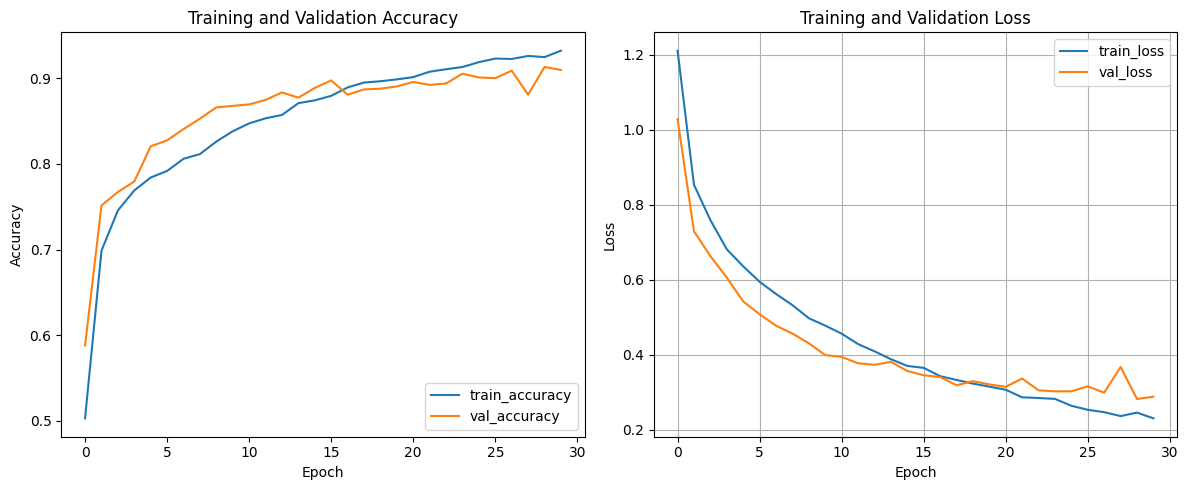


Avaliação do modelo final no conjunto de teste:
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.8428 - loss: 0.4748
Loss no teste: 0.3653
Acurácia no teste: 0.8902


In [3]:
# Link do Colab com o Drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf  # Biblioteca para criar a rede neural
from tensorflow import keras
from keras import callbacks
from keras import layers
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt  # Para visualizar imagens
import numpy as np  # Para manipulação de arrays
import os  # Para trabalhar com diretórios
from sklearn.model_selection import train_test_split # Importar train_test_split

# Definir o caminho do dataset
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Definir o novo tamanho da imagem
IMAGE_SIZE = (32, 32)

# Coletar caminhos de imagem e rótulos do conjunto de treinamento
image_paths = []
labels = []
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
class_to_label = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_to_label[class_name])

# Converter para numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Dividir o conjunto de treino em treino e validação
# Usando 80% para treino e 20% para validação (ajustável)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Carregar o conjunto de teste separadamente
test_dataset = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=32, # Ajustar o tamanho do batch
    shuffle=False,
    label_mode='categorical') # São mais de 2 classes, então é categorical

# Otimização de desempenho para o conjunto de teste
AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


# Data Augmentation - Define outside the model
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # Inversão horizontal
        layers.RandomRotation(0.05),       # Reduzindo a rotação para até 5% (0.05 radianos)
        # Removendo RandomZoom e RandomTranslation para simplificar
        # layers.RandomZoom(0.1),         # Zoom de até 10%
        # layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Deslocamento
       layers.RandomContrast(0.05),     # Reduzindo o ajuste de contraste (opcional)
    ],
    name="data_augmentation",
)

# Função para criar o modelo
def create_model(num_classes):
    model = keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.Rescaling(1./255), # Apply rescaling after input
        layers.Conv2D(16, (3,3), activation='relu'), # Reduzindo filtros
        layers.MaxPooling2D(pool_size=(2,2), strides=2), # Aumentando stride
        layers.Dropout(0.2), # Reduzindo dropout
        layers.Conv2D(32, (3,3), activation='relu'), # Reduzindo filtros
        layers.MaxPooling2D(pool_size=(2,2), strides=2), # Aumentando stride
        layers.Dropout(0.1), # Reduzindo dropout
        layers.Conv2D(64, (3,3), activation='relu'), # Reduzindo filtros
        layers.MaxPooling2D(pool_size=(2,2), strides=2), # Aumentando stride
        layers.Dropout(0.2), # Reduzindo dropout
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # Reduzindo neurônios e regularização
        layers.Dropout(0.2), # Reduzindo dropout
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"])
    return model

# Função para criar datasets de treino e validação a partir de caminhos e rótulos
def create_tf_dataset_split(image_paths, labels, num_classes, batch_size, shuffle=False, augment=False):
    # Função auxiliar para carregar e pré-processar imagens
    def load_image(image_path, label):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE) # Usar o novo tamanho da imagem
        label = tf.one_hot(label, num_classes)
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=AUTOTUNE)
    if augment:
         dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) # Aplica DA no treino
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset

# Criar datasets de treino e validação
train_dataset = create_tf_dataset_split(train_paths, train_labels, num_classes, batch_size=32, shuffle=True, augment=True)
val_dataset = create_tf_dataset_split(val_paths, val_labels, num_classes, batch_size=32)


# Criação e compilação do modelo final
model = create_model(num_classes)

# Early Stopping e Learning Rate para o treinamento
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Callback para salvar o melhor modelo
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


print("Training the model...")
history = model.fit(
    train_dataset,
    epochs=30, # Número de épocas
    validation_data=val_dataset, # Usar o conjunto de validação
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])


# Plotagem dos resultados do treinamento
plt.figure(figsize=(12, 5))

# Plotar Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Plotar Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Avaliação do modelo final no conjunto de teste
print("\nAvaliação do modelo final no conjunto de teste:")
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss no teste: {loss:.4f}")
print(f"Acurácia no teste: {accuracy:.4f}")

# DANDO PREDICT NO MODELO

In [12]:
# Carregar o modelo treinado (certifique-se de que o caminho está correto)
# Substitua pelo caminho onde você salvou seu melhor modelo
model_path = '/content/drive/MyDrive/PROJETO IA 2024-2025/modelos_salvos/melhor_modelo_tumores_sem_VC.keras'
loaded_model = keras.models.load_model(model_path)

# Função para carregar e pré-processar uma nova imagem
def load_and_preprocess_image(image_path, image_size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # Decodificar JPEG (ajuste se for outro formato)
    img = tf.image.resize(img, image_size)      # Redimensionar para o tamanho esperado pelo modelo
    img = tf.expand_dims(img, axis=0)           # Adicionar dimensão de batch (o modelo espera um batch de imagens)
    # Não aplicar rescaling ou data augmentation aqui, pois são para treino/validação.
    # A camada de Rescaling 1./255 já está no modelo.
    return img

# Caminho para a nova imagem que você quer prever
# Substitua por um caminho de imagem real
new_image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0011.jpg' # Exemplo de caminho de teste

# Definir o tamanho da imagem (deve ser o mesmo tamanho usado no treinamento)
IMAGE_SIZE_PREDICT = (32, 32) # Use o tamanho definido no treinamento

# Carregar e pré-processar a nova imagem
new_image = load_and_preprocess_image(new_image_path, IMAGE_SIZE_PREDICT)

# Fazer a previsão
predictions = loaded_model.predict(new_image)

# As previsões são probabilidades para cada classe.
# Para obter a classe prevista, pegamos o índice com a maior probabilidade.
predicted_class_index = np.argmax(predictions)

# Mapear o índice previsto de volta para o nome da classe
# Certifique-se de que 'class_names' esteja disponível ou defina-o aqui se necessário
# class_names = sorted(os.listdir("/kaggle/input/brain-tumor-mri-dataset/Training")) # Defina class_names se não estiver no escopo
predicted_class_name = class_names[predicted_class_index]

print(f"A imagem é prevista como: {predicted_class_name}")
print(f"Probabilidades por classe: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
A imagem é prevista como: pituitary
Probabilidades por classe: [[1.1903191e-05 4.9645349e-04 6.8430687e-05 9.9942327e-01]]


**Como usar:**

1.  **Atualize os caminhos:** Substitua o valor de `model_path` pelo caminho real do seu modelo salvo no Google Drive. Substitua o valor de `new_image_path` pelo caminho da imagem que você deseja prever.
2.  **Verifique `IMAGE_SIZE_PREDICT`:** Certifique-se de que `IMAGE_SIZE_PREDICT` é o mesmo tamanho de imagem (`(32, 32)`) que você usou durante o treinamento do modelo.
3.  **Verifique `class_names`:** Se a variável `class_names` não estiver definida globalmente, descomente e execute a linha que a define a partir do diretório "Training" para que o código possa mapear o índice previsto para o nome da classe.
4.  **Execute a célula:** Execute a célula de código para obter a previsão.

In [5]:
import os

test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Listar os diretórios dentro do diretório de teste
print("Diretórios dentro de:", test_dir)
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        print(f"- {class_name}/")
        # Opcional: Listar alguns arquivos dentro de cada subdiretório para referência
        files_in_class = os.listdir(class_path)
        print("  Primeiros 5 arquivos:", files_in_class[:5])

Diretórios dentro de: /kaggle/input/brain-tumor-mri-dataset/Testing
- pituitary/
  Primeiros 5 arquivos: ['Te-pi_0059.jpg', 'Te-pi_0024.jpg', 'Te-pi_0232.jpg', 'Te-pi_0286.jpg', 'Te-pi_0233.jpg']
- notumor/
  Primeiros 5 arquivos: ['Te-no_0016.jpg', 'Te-no_0292.jpg', 'Te-no_0137.jpg', 'Te-no_0346.jpg', 'Te-no_0141.jpg']
- meningioma/
  Primeiros 5 arquivos: ['Te-me_0148.jpg', 'Te-me_0062.jpg', 'Te-me_0303.jpg', 'Te-me_0179.jpg', 'Te-me_0089.jpg']
- glioma/
  Primeiros 5 arquivos: ['Te-gl_0066.jpg', 'Te-gl_0043.jpg', 'Te-gl_0166.jpg', 'Te-gl_0048.jpg', 'Te-gl_0028.jpg']
